## Load Packages

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pkg_resources
import seaborn as sns
#sns.set_theme(style="ticks")

# import sklearn libararies
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

#from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from numpy import mean
from numpy import std
from numpy import absolute

import lightgbm as lgb
import xgboost as xgb
import missingno as msno
from itertools import combinations_with_replacement

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")

## Data Handling

### Load Data

In [2]:
df = pd.read_excel('Wind_data.xlsx')

### Check the Data

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_tmp = df.copy()

# let's glimpse data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 3.2 MB


In [4]:
df.describe()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
count,3635,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,...,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00
mean,2019-10-22 23:15:08.170564096,0.19,4.53,3.94,5.12,5.12,5.56,2.52,3.93,3.39,...,5.13,4.69,5.46,4.79,6.08,4.86,5.76,5.96,5.70,5.44
min,2019-08-07 00:00:00,0.00,0.59,0.49,0.68,0.46,0.53,0.50,0.31,0.24,...,0.69,0.42,0.41,0.53,0.64,0.65,0.74,0.70,0.49,0.56
25%,2019-09-14 17:30:00,0.04,2.23,2.05,2.87,2.79,3.31,1.49,1.84,1.35,...,2.62,2.83,3.09,2.60,3.37,2.49,3.13,3.31,3.24,3.21
50%,2019-10-22 14:00:00,0.13,3.66,3.22,4.78,4.49,5.36,2.01,3.34,2.46,...,4.42,4.30,4.91,4.43,5.43,3.94,5.05,5.28,5.11,5.11
75%,2019-11-30 08:30:00,0.30,6.58,5.50,6.86,6.56,7.66,2.98,5.77,4.40,...,7.28,6.07,7.28,6.87,8.25,6.81,7.74,8.06,7.63,7.11
max,2020-01-07 23:00:00,0.73,14.66,13.13,14.64,23.04,17.43,13.20,11.81,19.15,...,15.47,15.78,16.71,13.53,19.80,15.99,22.66,18.91,16.64,18.08
std,NaN,0.17,2.79,2.37,2.71,3.21,2.69,1.66,2.40,2.83,...,2.99,2.48,3.01,2.56,3.39,2.96,3.50,3.32,3.14,2.80


In [5]:
df.sample(10)

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
2480,2019-11-20 03:00:00,0.09,1.61,1.92,7.80,3.36,5.00,1.11,6.86,2.14,...,1.35,1.70,1.91,5.32,3.75,1.70,3.43,3.09,1.63,2.78
1832,2019-10-23 05:00:00,0.17,5.96,5.39,9.78,4.13,5.16,2.00,7.63,0.82,...,6.05,2.04,2.68,4.79,5.05,4.95,6.87,4.56,2.56,3.39
139,2019-08-13 02:00:00,0.32,7.97,6.91,2.79,5.55,7.33,3.51,0.72,0.78,...,8.43,4.14,6.68,6.06,8.34,7.83,7.92,7.77,6.61,5.98
3452,2019-12-30 17:00:00,0.20,2.06,1.88,8.68,2.34,6.01,1.51,1.55,5.33,...,2.39,4.65,4.71,5.39,7.08,2.12,2.07,7.77,5.92,6.56
1572,2019-10-12 09:00:00,0.03,1.83,1.53,2.65,5.40,2.44,1.08,3.56,4.51,...,2.43,1.36,1.15,2.50,2.72,2.40,4.53,2.41,1.37,1.71
3582,2020-01-05 03:00:00,0.34,3.63,3.20,3.80,4.46,4.40,2.55,3.66,1.97,...,5.37,5.55,10.14,4.55,10.34,3.55,2.23,9.35,9.75,7.25
553,2019-08-30 22:00:00,0.46,5.92,5.23,6.36,3.52,9.90,3.28,1.62,0.78,...,6.03,5.08,6.99,9.22,9.05,5.54,5.75,8.46,7.01,7.08
420,2019-08-25 06:00:00,0.28,7.79,6.80,1.81,5.87,8.87,2.23,1.68,0.75,...,8.21,2.15,3.94,7.37,3.23,7.92,7.68,3.27,3.66,3.04
2832,2019-12-04 19:00:00,0.03,1.10,0.96,7.20,3.87,2.04,0.79,0.69,5.56,...,1.46,2.74,1.62,0.99,1.19,1.19,3.74,1.18,1.98,2.04
757,2019-09-08 10:00:00,0.34,6.76,7.19,13.88,7.92,13.12,1.75,9.19,4.56,...,5.41,4.86,7.87,9.15,8.42,6.70,8.81,7.74,7.71,6.33


### Analyzing Missing Data

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (NaN)'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

<Axes: >

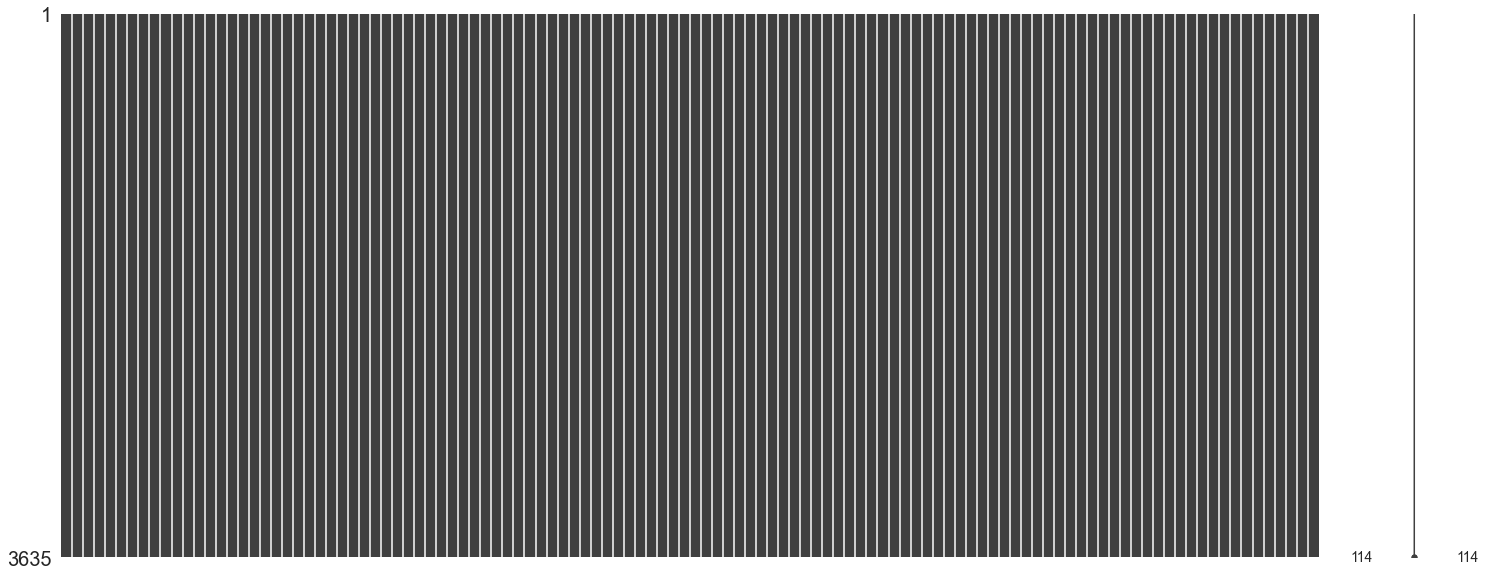

In [7]:
# Visualize missing data in dataset
msno.matrix(df)

### Percentage of missing data in each feature

In [8]:
missing_data(df)

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent (NaN),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Types,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Check Correlation between Features

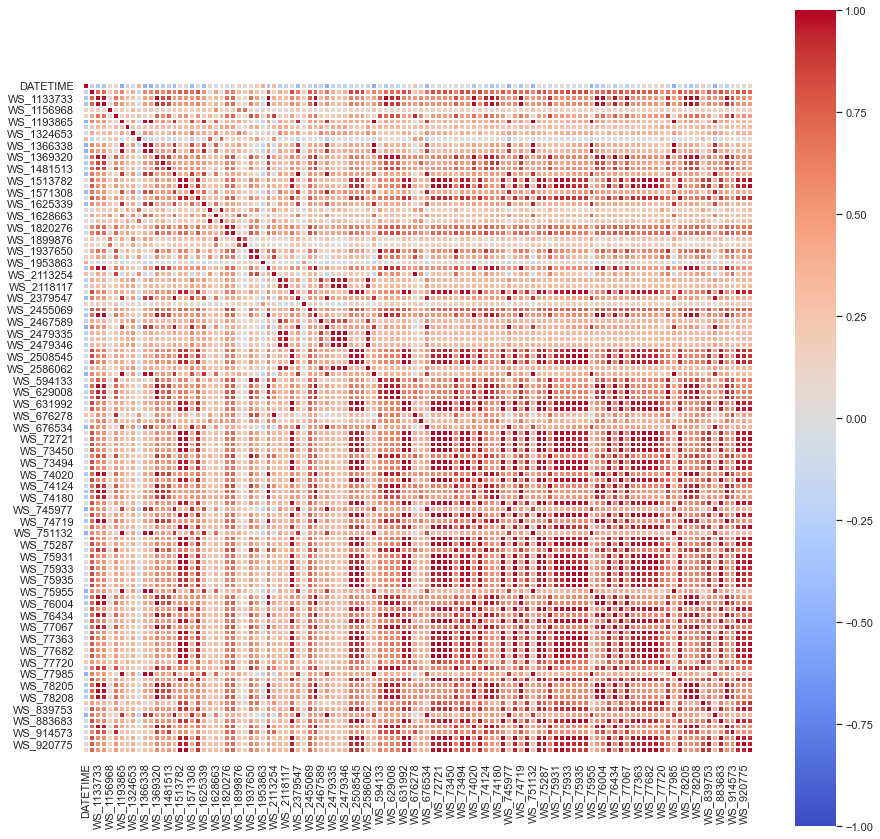

In [9]:
corr = df.corr()

fig, ax = plt.subplots(1, 1, figsize=(15,15))
sns.heatmap(corr, square=True, linecolor='white', linewidth=0.1, cmap='coolwarm', annot=False, vmax=1.0, vmin=-1.0)
plt.show()

In [10]:
pd.set_option('display.max_rows', None)

corr = df.corr()

# Sort by "CF" correlation
sorted_corr_CF = corr["CF"].sort_values(ascending=False)

# Print the sorted correlation values
print(sorted_corr_CF)

CF            1.00
WS_2503597    0.85
WS_2508550    0.84
WS_2508545    0.84
WS_75936      0.84
WS_75935      0.84
WS_75934      0.83
WS_77363      0.83
WS_631992     0.83
WS_2217107    0.83
WS_74022      0.83
WS_73494      0.82
WS_883683     0.82
WS_75933      0.82
WS_76888      0.82
WS_75287      0.82
WS_72733      0.82
WS_746023     0.82
WS_918665     0.81
WS_73822      0.81
WS_73450      0.80
WS_76275      0.80
WS_74243      0.80
WS_78026      0.80
WS_1574484    0.79
WS_72720      0.79
WS_75931      0.79
WS_651000     0.79
WS_75213      0.79
WS_77080      0.78
WS_839753     0.78
WS_72721      0.77
WS_77370      0.77
WS_77683      0.77
WS_2455069    0.76
WS_75932      0.76
WS_77682      0.76
WS_1513805    0.76
WS_920775     0.76
WS_1513782    0.75
WS_921049     0.73
WS_74020      0.73
WS_76004      0.73
WS_609612     0.73
WS_1133733    0.72
WS_74884      0.72
WS_1369320    0.72
WS_76434      0.72
WS_78208      0.72
WS_77067      0.72
WS_78205      0.72
WS_78207      0.72
WS_2460378  

In [11]:
# Calculate correlation
corr = df.corr()

# Filter features with correlation higher than 0.70
high_corr = corr[abs(corr['CF']) > 0.70].index

# Drop target variable 'CF' from the list of input features
high_corr = high_corr.drop('CF')

# Create a DataFrame with the selected features
df_high_corr = df[high_corr]

# Print the names of the selected features
print(high_corr)

Index(['WS_1133733', 'WS_1156770', 'WS_1369320', 'WS_1513782', 'WS_1513805',
       'WS_1574484', 'WS_1960535', 'WS_2217107', 'WS_2455069', 'WS_2460378',
       'WS_2503597', 'WS_2508545', 'WS_2508550', 'WS_609612', 'WS_631992',
       'WS_651000', 'WS_72720', 'WS_72721', 'WS_72733', 'WS_73450', 'WS_73494',
       'WS_73822', 'WS_74020', 'WS_74022', 'WS_74158', 'WS_74243', 'WS_746023',
       'WS_74719', 'WS_74884', 'WS_75213', 'WS_75287', 'WS_75931', 'WS_75932',
       'WS_75933', 'WS_75934', 'WS_75935', 'WS_75936', 'WS_76003', 'WS_76004',
       'WS_76275', 'WS_76434', 'WS_76888', 'WS_77067', 'WS_77080', 'WS_77363',
       'WS_77370', 'WS_77682', 'WS_77683', 'WS_78026', 'WS_78205', 'WS_78207',
       'WS_78208', 'WS_839753', 'WS_883683', 'WS_883699', 'WS_918665',
       'WS_920775', 'WS_921049'],
      dtype='object')


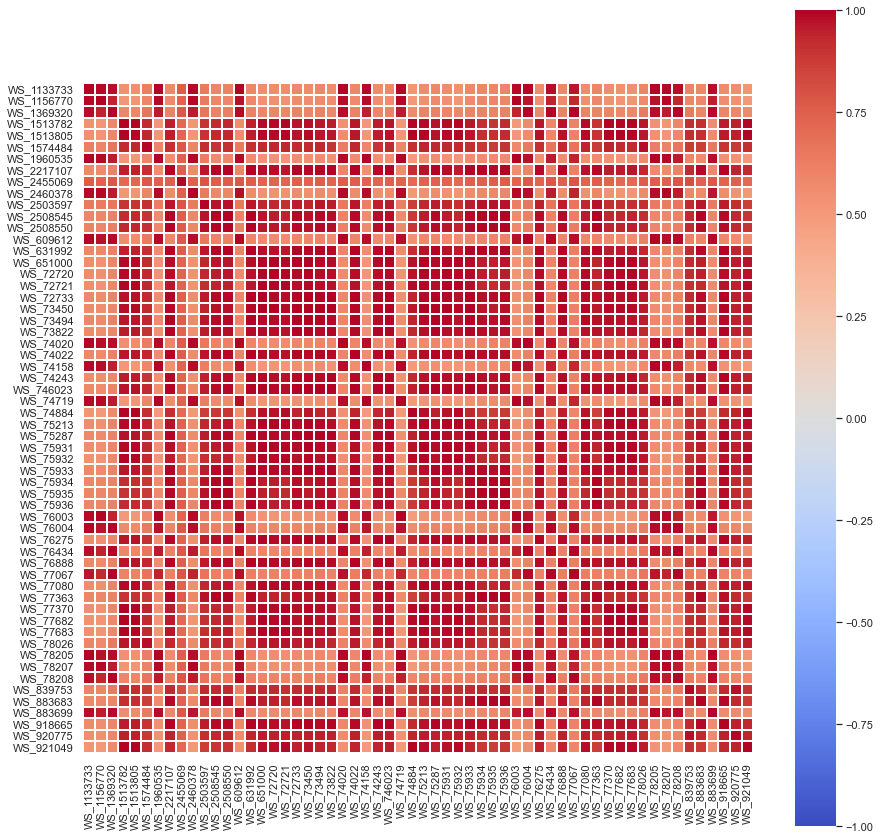

In [12]:
# Show correlation matrix
corr = df_high_corr.corr()

fig, ax = plt.subplots(1, 1, figsize=(15,15))
sns.heatmap(corr, square=True, linecolor='white', linewidth=0.1, cmap='coolwarm', annot=False, vmax=1.0, vmin=-1.0)
plt.show()

## Data Exploration for Each Column

In [13]:
# Define bins to cut CF into
bins = np.arange(0, df['CF'].max() + 0.1, 0.1) 

# Use pd.cut to cut CF into bins and add the CLASS column
df['CLASS'] = pd.cut(df['CF'], bins=bins, labels=False, include_lowest=True, right=False)

In [14]:
# Create empty lists
dfs_wells = []
classnames = []

grouped = df.groupby("CLASS")

#split up the data by well
for well, data in grouped:
    dfs_wells.append(data)
    classnames.append(well)

In [15]:
def create_plot(classname, dataframe, 
                curves_to_plot, depth_curve, 
                log_curves=[]):
    
    # Count the number of tracks we need
    num_tracks = len(curves_to_plot)
    
    # Setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    
    # Create a super title for the entire plot
    fig.suptitle(classname, fontsize=20, y=1.05)
    
    # Loop through each curve in curves_to_plot and create a track with that data
    for i, curve in enumerate(curves_to_plot):
        
        
        ax[i].plot(dataframe[curve], depth_curve)
        
        # Setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # We want to pass in the deepest depth first, so we are displaying the data 
        # from shallow to deep
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())

        # Only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('DATETIME', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
    
    plt.tight_layout()
    plt.show()

### Histogram

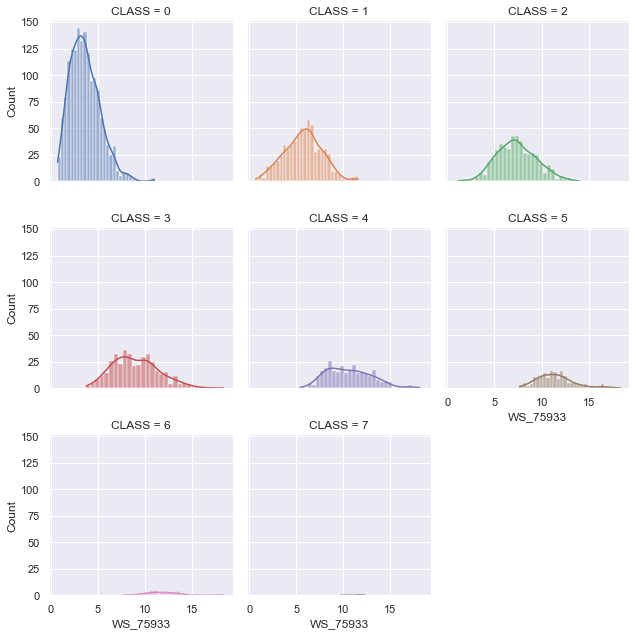

In [16]:
g = sns.FacetGrid(df, col='CLASS', hue='CLASS', col_wrap=3)
g.map(sns.histplot, 'WS_75933', kde=True, bins=30)

### Boxplot

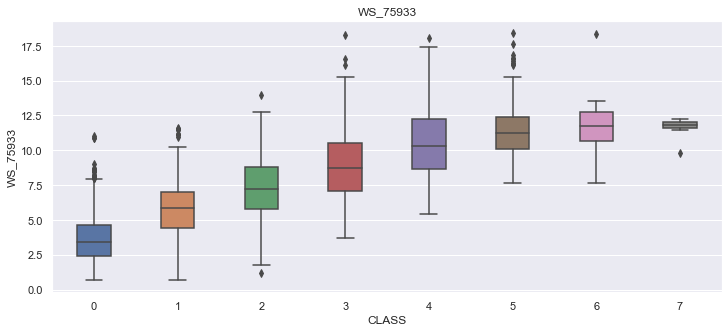

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
# Boxplot of Gamma Ray Per Well
sns.boxplot(data=df, x='CLASS', y='WS_75933', hue='CLASS', dodge =False, width=0.4 )
ax.set_title('WS_75933')
ax.get_legend().remove()

### Let's look at the characteristics of data together

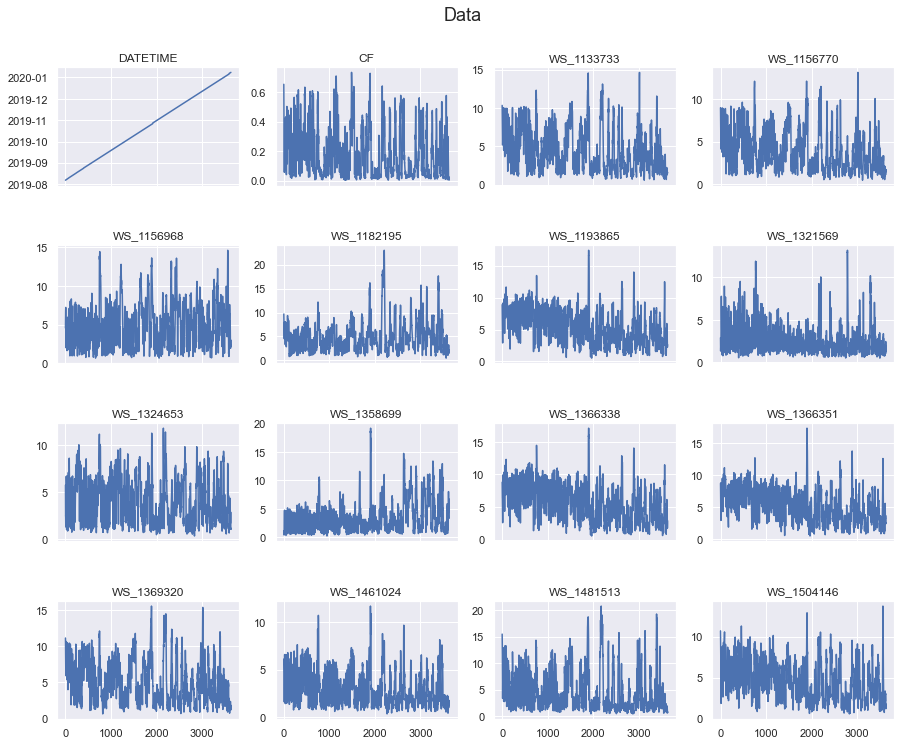

In [18]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12), sharex=True) 
plt.subplots_adjust(hspace=0.5) 
fig.suptitle("Data", fontsize=18, y=0.95)


# loop through tickers and axes
col_names = df.columns
for col_name, ax in zip(col_names, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[col_name].plot(ax=ax)

    # chart formatting
    ax.set_title(col_name.upper())

plt.show()

### Removing outlier

In [19]:
def remove_outlier(df, col_name):
    """
    Remove outlier in each features by replacing outliers to NAN
    df : dataframe
    col_name : string / column name
    """
    # define outlieer as larger/smaller by 3 standard deviation of each column data
    upper_limit = df[col_name].mean() + 3*df[col_name].std()
    lower_limit = df[col_name].mean() - 3*df[col_name].std()
    
    # mask as a NaN
    df[col_name] = np.where(df[col_name]>=upper_limit,
                     np.nan,
                     np.where(df[col_name]<=lower_limit,
                              np.nan,
                              df[col_name])
                    )

In [20]:
df_trim = df.copy()
remove_outlier(df_trim, col_names)   

Text(0.5, 1.0, 'No outlier')

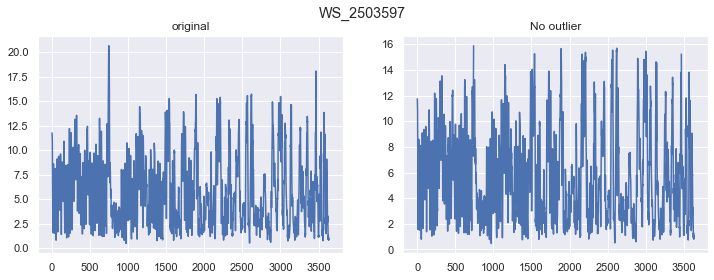

In [21]:
#comparing with / without outlier

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle('WS_2503597')

ax1.plot(df['WS_2503597'])
ax1.set_title('original')

ax2.plot(df_trim['WS_2503597'])
ax2.set_title('No outlier')

In [22]:
remove_outlier(df, col_names)  

### Filtering Nan based on Target Columns - Interpolation

In [23]:
# Convert all dataframe values to numeric, replacing non-numeric values with NaN
df_interpolated = df.apply(pd.to_numeric, errors='coerce')

# Fill NaN values by linearly interpolating between existing values
df_interpolated = df_interpolated.interpolate()

In [24]:
# check the NaN in each feature
for col in df.columns:
    print(col, df_interpolated[col].isna().sum())

DATETIME 0
CF 0
WS_1133733 0
WS_1156770 0
WS_1156968 0
WS_1182195 0
WS_1193865 0
WS_1321569 0
WS_1324653 0
WS_1358699 0
WS_1366338 0
WS_1366351 0
WS_1369320 0
WS_1461024 0
WS_1481513 0
WS_1504146 0
WS_1513782 0
WS_1513805 0
WS_1571308 0
WS_1574484 0
WS_1625339 0
WS_1625374 0
WS_1628663 0
WS_1681085 0
WS_1820276 0
WS_1820279 0
WS_1899876 0
WS_1911282 0
WS_1937650 0
WS_1937653 0
WS_1953863 0
WS_1960535 0
WS_2113254 0
WS_2113394 0
WS_2118117 0
WS_2217107 0
WS_2379547 0
WS_2385763 0
WS_2455069 0
WS_2460378 0
WS_2467589 0
WS_2467635 0
WS_2479335 0
WS_2479342 0
WS_2479346 0
WS_2503597 0
WS_2508545 0
WS_2508550 0
WS_2586062 0
WS_593968 0
WS_594133 0
WS_609612 0
WS_629008 0
WS_629020 0
WS_631992 0
WS_651000 0
WS_676278 0
WS_676403 0
WS_676534 0
WS_72720 0
WS_72721 0
WS_72733 0
WS_73450 0
WS_73451 0
WS_73494 0
WS_73822 0
WS_74020 0
WS_74022 0
WS_74124 0
WS_74158 0
WS_74180 0
WS_74243 0
WS_745977 0
WS_746023 0
WS_74719 0
WS_74884 0
WS_751132 0
WS_75213 0
WS_75287 0
WS_75812 0
WS_75931 0
WS_75932

In [25]:
missing_data(df_interpolated)

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049,CLASS
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent (NaN),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [26]:
df_interpolated.columns

Index(['DATETIME', 'CF', 'WS_1133733', 'WS_1156770', 'WS_1156968',
       'WS_1182195', 'WS_1193865', 'WS_1321569', 'WS_1324653', 'WS_1358699',
       ...
       'WS_811655', 'WS_839753', 'WS_875373', 'WS_883683', 'WS_883699',
       'WS_914573', 'WS_918665', 'WS_920775', 'WS_921049', 'CLASS'],
      dtype='object', length=115)

In [27]:
#df_interpolated = df_interpolated.drop(columns=['DATETIME'])

In [28]:
print(df_interpolated.columns)
print(df_interpolated.shape)
data = df_interpolated.copy()

Index(['DATETIME', 'CF', 'WS_1133733', 'WS_1156770', 'WS_1156968',
       'WS_1182195', 'WS_1193865', 'WS_1321569', 'WS_1324653', 'WS_1358699',
       ...
       'WS_811655', 'WS_839753', 'WS_875373', 'WS_883683', 'WS_883699',
       'WS_914573', 'WS_918665', 'WS_920775', 'WS_921049', 'CLASS'],
      dtype='object', length=115)
(3635, 115)


<Axes: >

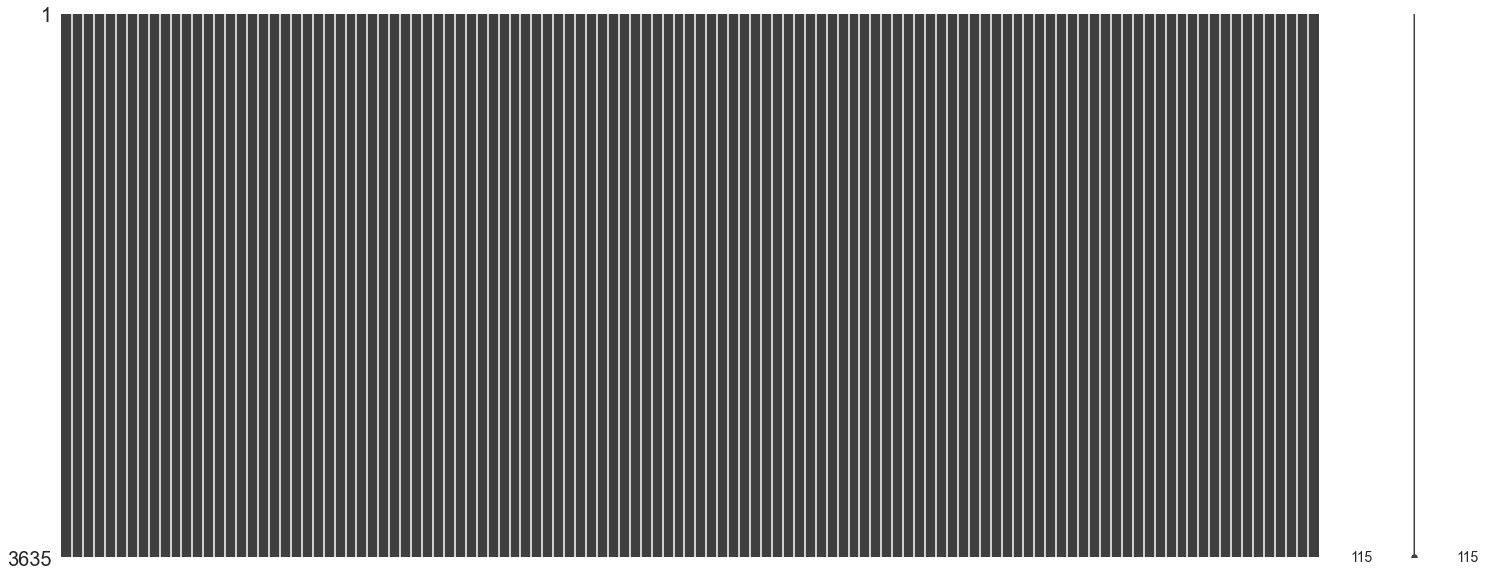

In [29]:
msno.matrix(data)

## Build Machine Learning Models

### Splitting the Dataset into Training and Testing Sets

In [30]:
# Make sure 'DATETIME' is datetime type
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

In [31]:
# Define the date range for the test set
start_date = '10/1/2019 12:00:00 AM'
end_date = '10/31/2019 11:00:00 PM'

In [32]:
# Split the data based on the date range
test = data[(data['DATETIME'] >= start_date) & (data['DATETIME'] <= end_date)]
train = data[~((data['DATETIME'] >= start_date) & (data['DATETIME'] <= end_date))]

In [33]:
# Create feature matrix X and target variable Y for both train and test sets
X_train = train.drop(columns=['CF', 'DATETIME']).values
y_train = train['CF'].values
X_test = test.drop(columns=['CF', 'DATETIME']).values
y_test = test['CF'].values

In [34]:
# Standardize the matrices for training and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # use the same scaler fit on train data

### Standardizing the Data

In [35]:
print("X_train: ", X_train.shape , ", y_train: ",y_train.shape)
print("X_test: ", X_test.shape , ", y_test: ",y_test.shape)

X_train:  (2912, 113) , y_train:  (2912,)
X_test:  (723, 113) , y_test:  (723,)


## Model Training - Random Forest

In [36]:
# Define the model 
model_RF = RandomForestRegressor(random_state=0)

# Define the parameters for the grid search
param_grid_RF = {
    'n_estimators': [100],
    'max_depth': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5,  random_state=123)

# Set up the grid search
grid_RF = GridSearchCV(model_RF, 
                    param_grid=param_grid_RF, 
                    scoring='neg_mean_absolute_error', 
                    cv=cv, 
                    n_jobs=-1)

# Fit the model
grid_RF.fit(X_train, y_train)

# Create a DataFrame with the results
scores_df_RF = pd.DataFrame(grid_RF.cv_results_)

# Print best parameters after tuning 
print(grid_RF.best_params_) 

{'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [37]:
# Save the results to a csv file
scores_df_RF.to_csv("random_forest_gridsearch.csv")

# Print scores
print(scores_df_RF.transpose())

                                                                         0
mean_fit_time                                                        89.40
std_fit_time                                                          6.47
mean_score_time                                                       0.03
std_score_time                                                        0.00
param_bootstrap                                                       True
param_max_depth                                                        100
param_min_samples_leaf                                                   1
param_min_samples_split                                                  2
param_n_estimators                                                     100
params                   {'bootstrap': True, 'max_depth': 100, 'min_sam...
split0_test_score                                                    -0.02
split1_test_score                                                    -0.02
split2_test_score        

In [38]:
# Initialize the model with the best parameters
model_RF = RandomForestRegressor(**grid_RF.best_params_)

# Fit the model to the training data
model_RF.fit(X_train, y_train)

# Predict the targets for the test data
y_pred_RF = model_RF.predict(X_test)

# Calculate the mean absolute error of the model
mae_RF = mean_absolute_error(y_test, y_pred_RF)

print(f'Test MAE: {mae_RF}')

Test MAE: 0.01871215665324307


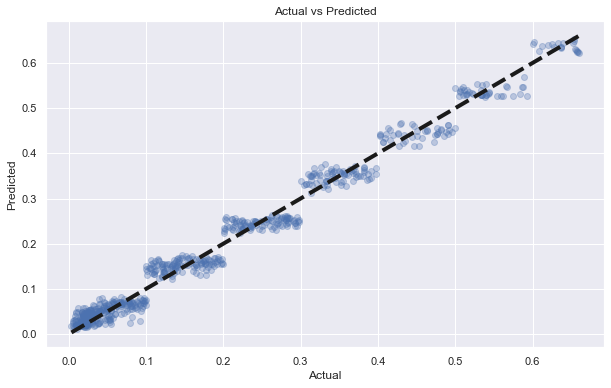

In [39]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_RF, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

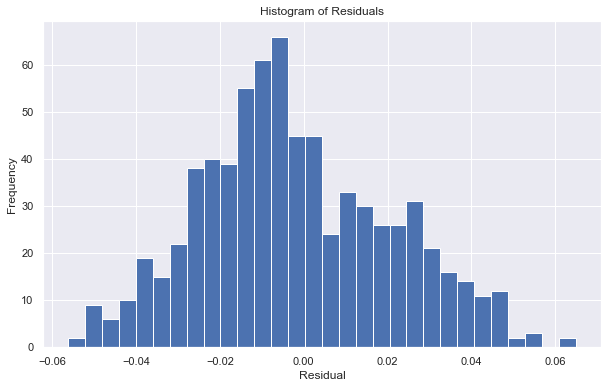

In [40]:
# Calculate residuals
residuals_RF = y_test - y_pred_RF

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals_RF, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Training - LGBM

In [41]:
# Define the model 
model_lgbm = lgb.LGBMRegressor()

# Define the parameters for the grid search
param_grid_lgbm = {'estimator__n_estimator': [200],
              'estimator__num_leaves' : [10],
              'estimator__max_depth' : [-1],
              'estimator__min_child_samples' : [20, 40],
              'estimator__subsample' : [1],
              'estimator__learning_rate' : [0.05]}

#param_grid_lgbm = {'estimator__n_estimator': [200, 400, 800, 1000, 1200],
#              'estimator__num_leaves' : [10, 20, 40, 50, 60, 70, 80, 90, 100],
#              'estimator__max_depth' : [-1],
#              'estimator__min_child_samples' : [20, 40, 60],
#              'estimator__subsample' : [1],
#              'estimator__learning_rate' : [0.05]}

cv = RepeatedKFold(n_splits=5,  random_state=123)

grid_lgbm = GridSearchCV(model_lgbm, 
                    param_grid=param_grid_lgbm,
                    scoring='neg_mean_absolute_error', 
                    cv=cv, 
                    n_jobs=-1)

grid_lgbm.fit(X_train,y_train)

scores_df_lgbm = pd.DataFrame(grid_lgbm.cv_results_)

# print best parameter after tuning 
print(grid_lgbm.best_params_) 

[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28568
[LightGBM] [Info] Number of data point

In [42]:
# save to csv
scores_df_lgbm.to_csv("light_gbm_grisearch.csv")

# print scores
print(scores_df_lgbm.transpose())

                                                                                    0  \
mean_fit_time                                                                   14.70   
std_fit_time                                                                     6.10   
mean_score_time                                                                  0.03   
std_score_time                                                                   0.06   
param_estimator__learning_rate                                                   0.05   
param_estimator__max_depth                                                         -1   
param_estimator__min_child_samples                                                 20   
param_estimator__n_estimator                                                      200   
param_estimator__num_leaves                                                        10   
param_estimator__subsample                                                          1   
params               

In [43]:
# Initialize the model with the best parameters
model_lgbm = lgb.LGBMRegressor(**grid_lgbm.best_params_)

# Fit the model to the training data
model_lgbm.fit(X_train, y_train)

# Predict the targets for the test data
y_pred_lgbm= model_lgbm.predict(X_test)

# Calculate the mean absolute error of the model
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f'Test MAE: {mae_lgbm}')

[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28568
[LightGBM] [Info] Number of data point

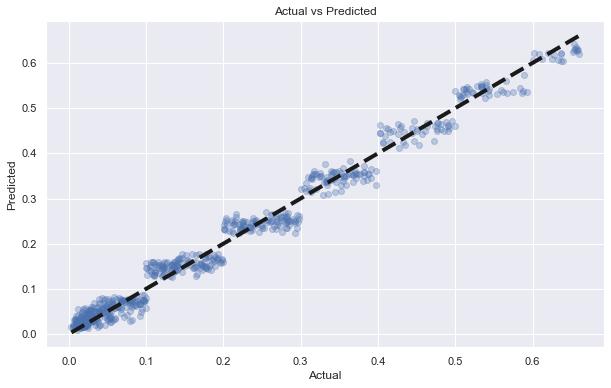

In [44]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

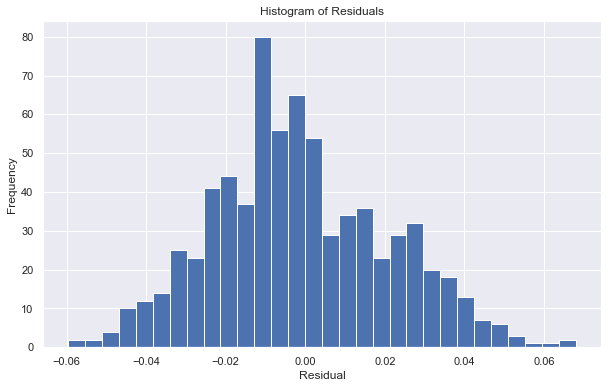

In [45]:
# Calculate residuals
residuals_lgbm = y_test - y_pred_lgbm

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals_lgbm, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Training - XGBoost

In [46]:
# Define the model 
model_xgb = xgb.XGBRegressor()

# Define the parameters for the grid search
param_grid_xgb = {'estimator__learning_rate' : [0.01],
              'estimator__n_estimator': [200],
              'estimator__max_depth' : [3],
              'estimator__max_leaf_nodes': [100],
              'estimator__min_child_weight' : [1],
              'estimator__colsample_bytree' : [0.3],
              'estimator__subsample' : [1],
              'estimator__reg_lamda' : [1],
              'estimator__reg_alpha' : [0.00]}

#param_grid_xgb = {'estimator__learning_rate' : [0.01, 0.05, 0.1],
#              'estimator__n_estimator': [200, 800, 1600],
#              'estimator__max_depth' : [3, 6, 10, 20],
#              'estimator__max_leaf_nodes': [100],
#              'estimator__min_child_weight' : [1],
#              'estimator__colsample_bytree' : [0.3, 0.7, 1.0],
#              'estimator__subsample' : [1],
#              'estimator__reg_lamda' : [1],
#              'estimator__reg_alpha' : [0.00]}


cv = RepeatedKFold(n_splits=5,  random_state=123)

grid_xgb = GridSearchCV(model_xgb, 
             param_grid=param_grid_xgb,
             scoring='neg_mean_absolute_error',
             cv=cv, # cv, 
             n_jobs=-1)

grid_xgb.fit(X_train,y_train)

scores_df_xgb = pd.DataFrame(grid_xgb.cv_results_)

# print best parameter after tuning 
print(grid_xgb.best_params_) 

[07:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__max_leaf_nodes", "estimator__min_child_weight", "estimator__n_estimator", "estimator__reg_alpha", "estimator__reg_lamda", "estimator__subsample" } are not used.

{'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__max_leaf_nodes': 100, 'estimator__min_child_weight': 1, 'estimator__n_estimator': 200, 'estimator__reg_alpha': 0.0, 'estimator__reg_lamda': 1, 'estimator__subsample': 1}


In [47]:
# save to csv
scores_df_xgb.to_csv("xgb_grisearch.csv")

# print scores
print(scores_df_xgb.transpose())

                                                                                   0
mean_fit_time                                                                  36.10
std_fit_time                                                                    8.60
mean_score_time                                                                 0.03
std_score_time                                                                  0.08
param_estimator__colsample_bytree                                               0.30
param_estimator__learning_rate                                                  0.01
param_estimator__max_depth                                                         3
param_estimator__max_leaf_nodes                                                  100
param_estimator__min_child_weight                                                  1
param_estimator__n_estimator                                                     200
param_estimator__reg_alpha                                       

In [48]:
# Initialize the model with the best parameters
model_xgb = xgb.XGBRegressor(**grid_xgb.best_params_)

# Fit the model to the training data
model_xgb.fit(X_train, y_train)

# Predict the targets for the test data
y_pred_xgb = model_xgb.predict(X_test)

# Calculate the mean absolute error of the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f'Test MAE: {mae_xgb}')

[07:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__max_leaf_nodes", "estimator__min_child_weight", "estimator__n_estimator", "estimator__reg_alpha", "estimator__reg_lamda", "estimator__subsample" } are not used.

Test MAE: 0.018449536649252


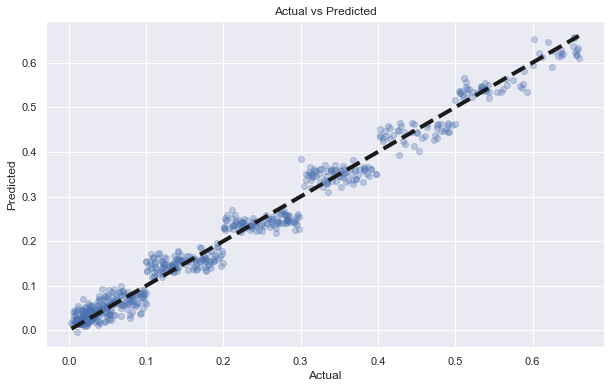

In [49]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

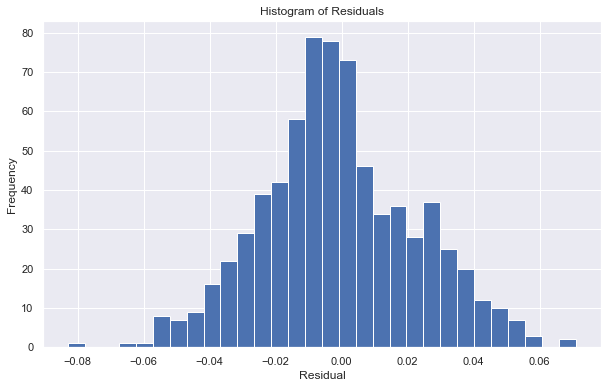

In [50]:
# Calculate residuals
residuals_xgb = y_test - y_pred_xgb

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals_xgb, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Training - CNN

In [51]:
# Reshaping data
X_train_CNN = X_train.reshape(-1, X_train.shape[1], 1)
y_train = y_train.astype('float32')

In [52]:
# Hyperparameters to tune
neurons = [8, 16, 32, 64, 128, 256]

# Set early stopping criteria
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

best_mae_cnn = np.inf
best_neurons_cnn = None
best_model_cnn = None

In [53]:
for n in neurons:
    model_cnn = Sequential()
    model_cnn.add(Conv1D(n, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Conv1D(n, kernel_size=3, activation='relu'))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(n, activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(1))
    model_cnn.compile(optimizer=Adam(), loss='mean_absolute_error')

    model_cnn.fit(X_train_CNN, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[earlystopping], verbose=0)

    # Get predictions on train set and calculate MAE
    train_predictions_cnn = model_cnn.predict(X_train)
    mae_cnn = mean_absolute_error(y_train, train_predictions_cnn)

    print(f'Neurons: {n}, Train MAE: {mae_cnn}')
    
    # If current MAE is better than previous best, update best MAE and save model
    if mae_cnn < best_mae_cnn:
        best_mae_cnn = mae_cnn
        best_neurons_cnn = n
        best_model_cnn = model_cnn

Epoch 15: early stopping
91/91 [==============================] - 0s 2ms/step
Neurons: 8, Train MAE: 0.03934590518474579
Epoch 18: early stopping
91/91 [==============================] - 0s 2ms/step
Neurons: 16, Train MAE: 0.03181162849068642
Epoch 17: early stopping
91/91 [==============================] - 0s 2ms/step
Neurons: 32, Train MAE: 0.031029928475618362
Epoch 13: early stopping
91/91 [==============================] - 0s 3ms/step
Neurons: 64, Train MAE: 0.03025294467806816
Epoch 12: early stopping
91/91 [==============================] - 1s 5ms/step
Neurons: 128, Train MAE: 0.030080417171120644
Epoch 22: early stopping
91/91 [==============================] - 1s 9ms/step
Neurons: 256, Train MAE: 0.029766004532575607


In [54]:
print(f'Best Model, Neurons: {best_neurons_cnn}, Train MAE: {best_mae_cnn}')

Best Model, Neurons: 256, Train MAE: 0.029766004532575607


In [55]:
# Reshape X_test
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Use the best model to make predictions on the test set
y_pred_cnn = best_model_cnn.predict(X_test_cnn)

# Calculate MAE on the test set
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

print(f'Test MAE: {mae_cnn}')

23/23 [==============================] - 0s 9ms/step
Test MAE: 0.040540992326780684


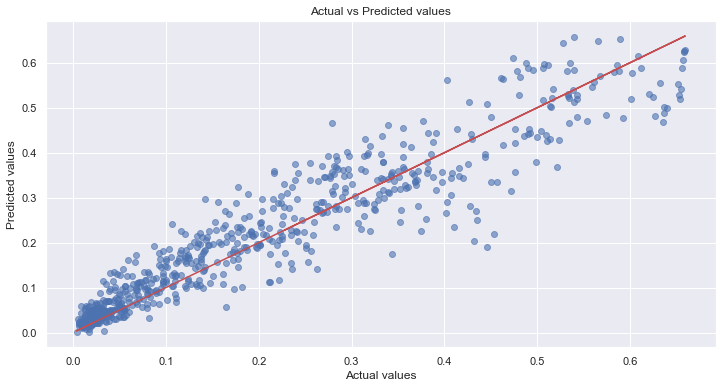

In [56]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_cnn, alpha=0.6)
plt.plot(y_test, y_test, 'r')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

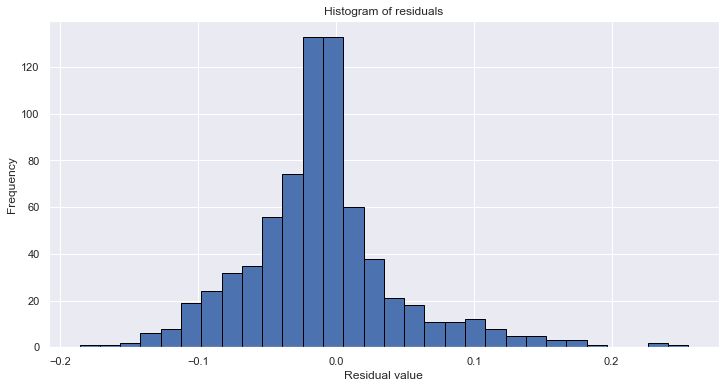

In [57]:
# Calculate residuals
residuals_cnn = y_test - y_pred_cnn.flatten()

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals_cnn, bins=30, edgecolor='black')
plt.title('Histogram of residuals')
plt.xlabel('Residual value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Model Training - LSTM

In [58]:
# Hyperparameters to tune
neurons = [8, 16, 32, 64, 128, 256]

In [59]:
# Set early stopping criteria
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

best_mae_lstm = np.inf
best_neurons_lstm = None
best_model_lstm = None

In [60]:
for n in neurons:
    X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(n, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(n, activation='relu'))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(n, activation='relu'))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer=Adam(), loss='mean_absolute_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[earlystopping], verbose=0)

    # Get predictions on train set and calculate MAE
    train_predictions = model_lstm.predict(X_train_lstm)
    mae_lstm = mean_absolute_error(y_train, train_predictions)

    print(f'Neurons: {n}, Train MAE: {mae_lstm}')

    # If current MAE is better than previous best, update best MAE and save model
    if mae_lstm < best_mae_lstm:
        best_mae_lstm = mae_lstm
        best_neurons_lstm = n
        best_model_lstm = model_lstm

print(f'Best Model, Neurons: {best_neurons_lstm}, Train MAE: {best_mae_lstm}')

Epoch 28: early stopping
91/91 [==============================] - 0s 1ms/step
Neurons: 8, Train MAE: 0.05438278615474701
Epoch 47: early stopping
91/91 [==============================] - 0s 1ms/step
Neurons: 16, Train MAE: 0.025223182514309883
Epoch 29: early stopping
91/91 [==============================] - 0s 2ms/step
Neurons: 32, Train MAE: 0.025542227551341057
Epoch 45: early stopping
91/91 [==============================] - 0s 2ms/step
Neurons: 64, Train MAE: 0.02048429101705551
Epoch 30: early stopping
91/91 [==============================] - 1s 2ms/step
Neurons: 128, Train MAE: 0.016649983823299408
Epoch 31: early stopping
91/91 [==============================] - 1s 4ms/step
Neurons: 256, Train MAE: 0.015756109729409218
Best Model, Neurons: 256, Train MAE: 0.015756109729409218


In [61]:
# Testing on X_test similar to the CNN model
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

y_pred_lstm = best_model_lstm.predict(X_test_lstm)

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f'Test MAE: {mae_lstm}')

23/23 [==============================] - 0s 4ms/step
Test MAE: 0.021378308976772408


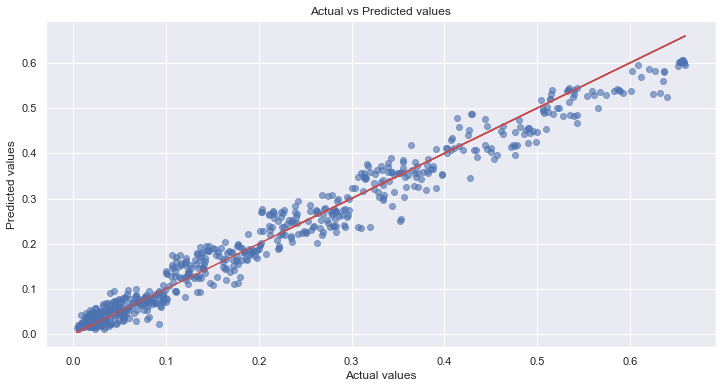

In [62]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.6)
plt.plot(y_test, y_test, 'r')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

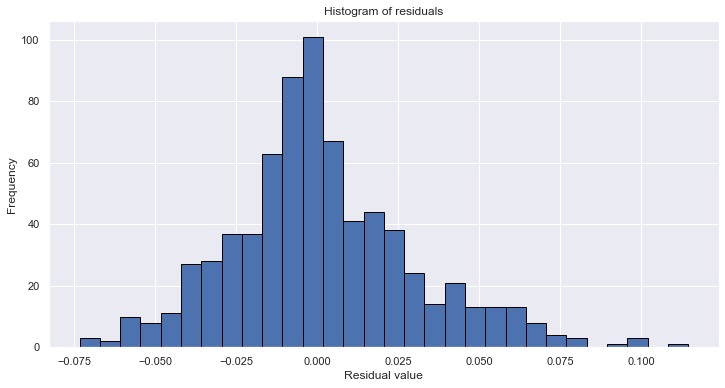

In [63]:
# Calculate residuals
residuals_lstm = y_test - y_pred_lstm.flatten()

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals_lstm, bins=30, edgecolor='black')
plt.title('Histogram of residuals')
plt.xlabel('Residual value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Summary Table

In [64]:
pd.set_option('display.float_format', '{:.5f}'.format)

# Create a dictionary to store the MAE
data = {'Random Forest': [mae_RF],
        'Light GBM': [mae_lgbm],
        'XG Boost': [mae_xgb],
        'CNN': [mae_cnn],
        'LSTM': [mae_lstm]}

# Convert the dictionary to a pandas DataFrame
df_mae = pd.DataFrame(data, index=['MAE'])

# Print the DataFrame
print(df_mae)

     Random Forest  Light GBM  XG Boost     CNN    LSTM
MAE        0.01871    0.01796   0.01845 0.04054 0.02138
